#### **Automated Polysomnography (PSG) Preprocessing Pipeline Tutorial**

This document introduces a PSG preprocessing pipeline adaptable to various age groups, cap densities, brands, desired sleep stages, and channel types. Users can either follow a standardized procedure for rapid processing of all files or customize the functions based on their analysis.

The standardized procedure includes the following steps:

  - 1. Read and clean data to a standardized format, define the desired electrode montage.

  - 2. Downsample and filter data to a limited frequency range used for PSG analysis.

  - 3. Add online reference channel back to data and rereference to contralateral mastoids.

  - 4. Read the sleep stage scoring file and classify the PSG data into corresponding stages.

  - 5. Detect and interpolate artifacts. Optionally, provide visual inspection of artifacts.

  - 6. Perform ICA to further remove eye, cardial, muscle, and other artifacts.
  
  - 7. Generate diagnostic plots for each file, save the cleaned files to the specified folder.

In [1]:
# ----------------- Load packages ------------------- #
import os
import contextlib
import io
import numpy as np
import pandas as pd
import mne
from scipy.io import loadmat
from AutoPSG import *
from AutoPSG.artifact_detect import load_raw, annotate_epoch_chan, load_hypnogram_data, good_epoch_dur, hypnogram_segment, badchan_var
from AutoPSG.artifact_detect import zscoreamp_epoch_epochwise, zscoreamp_epoch_chanwise, flat_epoch, ptpamp_epoch, threshold_badchan, threshold_badepoch
from AutoPSG.artifact_detect import reject_bad_epoch, interpolate_by_epoch, plot_bad_artifacts, auto_artifact_detect_interp, apply_ica_by_stage

**To prepare files for standardized preprocessing procedures:**

1. Create a single folder to store all PSG data.

2. Create three subfolders within the main folder (your may change to other names):

   - "raw" to store unpreprocessed PSG files. It supports most of file types.

   - "preproc" to store preprocessed PSG files.
   
   - "scoring" to store sleep stage scoring files. It currently only supports mat. file; txt. and csv. file types will soon be supported.
     - Each scoring file should contain sleep stages scored by 30s, with 0 = Wake, 1 = N1, 2 = N2, 3 = SWS, and 4 = REM.

3. Add the raw and scoring files for each participant to their respective folder, ensure that the filenames for both the raw data and scoring file are identical.

   e.g. **PSG_01_wordtask.edf** (raw data), and **PSG_01_wordtask.mat** (scoring file) for participant 01.
                
      **PSG_02_wordtask.edf** (raw data), and **PSG_02_wordtask.mat** (scoring file) for participant 02.

The data structure before preprocessing should be similar to:

- data
  - raw
    - PSG_01_wordtask.edf
    - PSG_02_wordtask.edf
    - ...
  - preproc (empty)

  - scoring
    - PSG_01_wordtask.mat
    - PSG_02_wordtask.mat
    - ...

3. Specify your montage, sleep stages of interest, channels of interest, and reference channels used below following the instruction.

4. Run!

**To customize the preprocessing steps:**

- You can modify the code within the pipeline to update functions based on your analysis.

- Also check the next section of this tutorial to learn how to customize the process of artifact detection and interpolation.

Start preprocessing for subject EMO101_N.
Sampling frequency of the instance is already 200.0, returning unmodified.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Bad channels detected by variance threshold: ['CP4', 'AF7']
Artifact detection by peak-to-peak amplitude completed, 1073 artifacts identified
Artifact detection by epoch-wise mean amplitude threshold completed, 559 artifacts identified
Artifact detection by channel-wise amplitude threshold completed, 394 artifacts identified
Artifact detection by the flat line threshold completed, 0 artifacts identified
Bad channel detection by the percentage of artifact epochs completed
Total number of bad channels: 3 ['CP4', 'AF7', 'FCC2h']


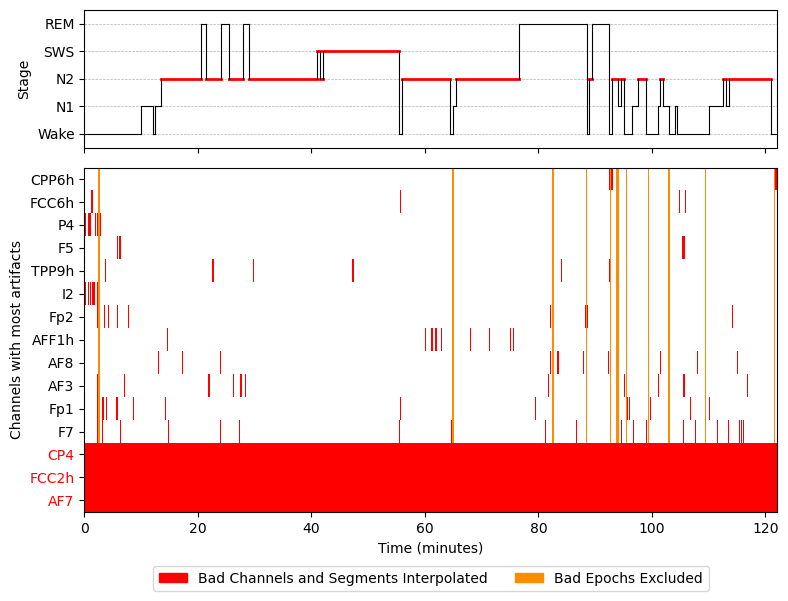

Interpolating 205 artifacts in 130 epochs ...
Artifact interpolation completed
Processing dimension reduction and ICA for 42 segments.


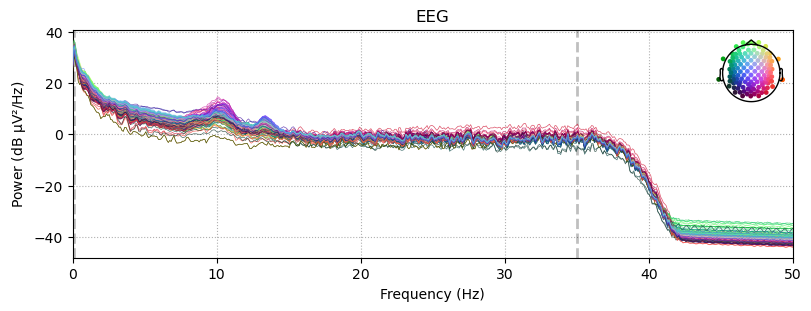

Start preprocessing for subject EMO102_N.
Sampling frequency of the instance is already 200.0, returning unmodified.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Bad channels detected by variance threshold: ['CP3', 'CCP2h']
Artifact detection by peak-to-peak amplitude completed, 412 artifacts identified
Artifact detection by epoch-wise mean amplitude threshold completed, 474 artifacts identified
Artifact detection by channel-wise amplitude threshold completed, 550 artifacts identified
Artifact detection by the flat line threshold completed, 0 artifacts identified
Bad channel detection by the percentage of artifact epochs completed
Total number of bad channels: 4 ['CP3', 'CCP2h', 'AF7', 'AF8']


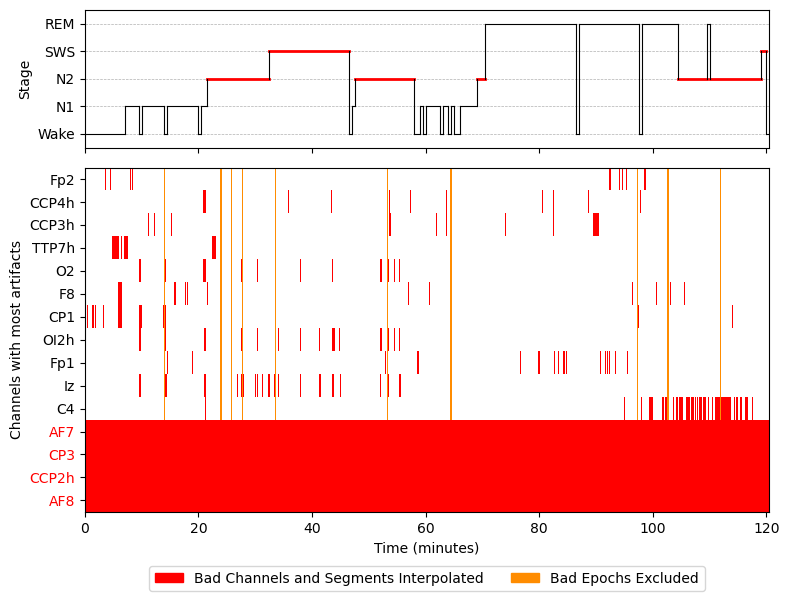

Interpolating 401 artifacts in 241 epochs ...
Artifact interpolation completed
Processing dimension reduction and ICA for 34 segments.


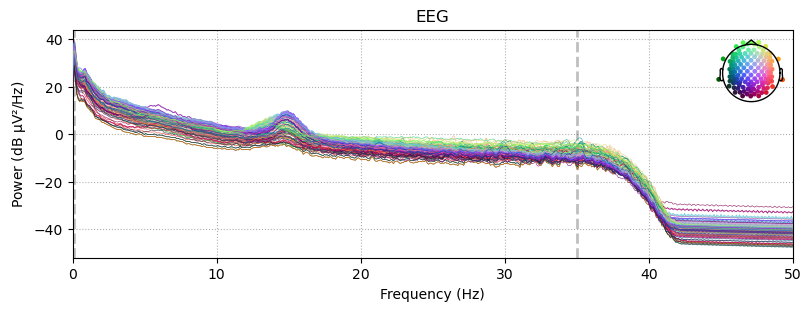

In [ ]:
##################################### Parameter Settings for the Pipeline ######################################
os.chdir('/Users/somneuro/Desktop/PSG/data')
raw_file = 'raw/'
processed_file = 'preproc/'
scoring_file = 'scoring/'
montage_temp = 'standard_1005'
# Use standard_1005 for mid and high-density caps, standard_1020 for low-density caps, or specify another montage.
interest_stage = ['N2', 'SWS'] # Highlight your interested sleep stages in diagnostic plots.
online_refer = 'FCz' #reference channel initially used during recording, set to None if it is already included in data.
rerefer = ['M1', 'M2']
# It is not recommended to set the average reference at this step, user can rereference to average after preprocessing.
epoch_dur = 10 # (in seconds) the dueation of each epoch uses to detect artifacts
scoring_dur = 30 # (in seconds) the duration of each epoch used for sleep scoring
chan_limit = None # Use None to preprocess all channels, or use ['Fz', 'Cz', ...] to preprocess selected channels only.
ICA = True # Performing ICA for each file may take about 5 min. it only takes 1-3 min for high-density PSG data without ICA.

####################################### Automated Preprocessing Pipeline #######################################
## DO NOT CHANGE THE FOLLOWING CODE IF YOU DO NOT PLAN TO MODIFY, DEBUG, OR CUSTOMIZE THE PREPROCESSING STEPS
file_paths = [os.path.join(raw_file, f) for f in os.listdir(raw_file) if f.endswith(('.vhdr', '.edf', '.fif', '.set', '.fdt', '.bdf', '.cnt'))]
for file_path in file_paths:
    id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"\033[1mStart preprocessing for subject {id}.\033[0m")
    raw = load_raw(file_path)
    raw.set_annotations(None)
    if chan_limit is not None:
         raw = raw.pick_channels(raw.info["ch_names"], include=chan_limit)

    # Standardize channel names
    raw.get_channel_types()
    chan_types = {
        "M1": "eeg", "M2": "eeg", "I1": "eeg", "I2": "eeg", "EOG1": "eog", 
        "EOG2": "eog", "EMG1": "emg", "EMG2": "emg", "EMG3": "emg", "ECG": "ecg"
    } ## mne usually does not recognize these channels, add more if necessary
    existing_chan = {ch_name: ch_type for ch_name, ch_type in chan_types.items() if ch_name in raw.ch_names}
    raw.set_channel_types(existing_chan)
    if 'FPz' in raw.ch_names:
        raw.rename_channels({'FPz': 'Fpz'}) ## mne used a different channel name for Fpz compared to most PSG caps
    rename_dict = {ch: ch.replace('Z', 'z') for ch in raw.ch_names if 'Z' in ch}
    rename_dict.update({ch: ch.replace('FP', 'Fp') for ch in raw.ch_names if 'Z' in ch})
    raw.rename_channels(rename_dict)
   
    drop_channels = [ch for ch in raw.ch_names if 'x_dir' in ch or 'y_dir' in ch or 'z_dir' in ch]
    drop_channels += [ch for ch in raw.ch_names if ch.isnumeric()]
    drop_channels += [ch for ch in raw.ch_names if "CHIN" in ch]
    raw.drop_channels(drop_channels)

    # Downsampling and filtering
    raw.resample(sfreq=200)
    raw.notch_filter(freqs=60, method='fir', fir_window='hamming', phase='zero', verbose='ERROR')
    ch_types = set(raw.get_channel_types())
    for ch_type in ch_types:
        if ch_type == 'eeg' or ch_type == 'eog':
                raw.filter(l_freq=0.1, h_freq=35, picks=[ch_type], method='fir', fir_window='hamming', phase='zero', verbose='ERROR')
        elif ch_type == 'emg':
                raw.filter(l_freq=10, h_freq=99.99, picks=[ch_type], method='fir', fir_window='hamming', phase='zero', verbose='ERROR')

    # Add online reference channels back
    if online_refer:
        raw = mne.add_reference_channels(raw, ref_channels=(online_refer))

    # Set the montage
    montage = mne.channels.make_standard_montage(montage_temp)
    raw.set_montage(montage)

    # Set EEG reference
    raw.set_eeg_reference(ref_channels=(rerefer))

    # Segment raw data into sleep stages
    stage = hypnogram_segment(raw=raw, interval=scoring_dur, file_paths=os.path.join(scoring_file, f"{id}.mat"))

    # Detect and interpolate artifacts
    auto_artifact_detect_interp(raw, stage=stage, picks=['eeg'], reference=(rerefer), epoch_length=epoch_dur,
                                interest_stage=interest_stage, visual=False) # set visual=True to visually inspect bad channels and artifacts

    # Apply ICA
    if ICA:
        run_emg = 'emg' in ch_types
        run_ecg = 'ecg' in ch_types
        run_eog = 'eog' in ch_types
        stage = hypnogram_segment(raw=raw, interval=scoring_dur, file_paths=os.path.join(scoring_file, f"{id}.mat"))
        apply_ica_by_stage(raw=raw, stage=stage, n_component=0.99, kurt_threshold_z=3, run_ecg=run_ecg,
                           run_emg=run_emg, run_eog=run_eog, run_kurtosis=True, visual=False) # set visual=True to visually select bad components to drop

    save_path = os.path.join(processed_file, f"{id}.fif")
    raw.save(save_path, overwrite=True, verbose='ERROR')

    with contextlib.redirect_stdout(io.StringIO()), warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        raw.compute_psd(fmin=0, fmax=50, reject_by_annotation=False).plot()
    fig = plt.gcf()
    fig.set_size_inches(8, 3)
    plt.show()
    del raw, stage, id

This pipeline generates two plots for each file:
- The first plot summarizes bad channels, bad epochs, and bad segments within each channel that contain artifacts identified throughout the recording. It marks the name of top 15 channels that contain most artifacts. Red segments in the hypnogram highlight the interested stage specified. You can use this plot to quickly check if a file contain too many artifacts or problematic channels.

- The second plot provides a power spectral density plot to overview the cleanness of data in each frequency range after preprocessing.

**Customized artifact detection and interpolation**

- Instead of directly run a pre-specified function to handle artifacts, you can choose to replace **auto_artifact_detect_interp** with the following code.

- We have provided a separate document for the usage of each function below, you can modify the code based on your goals of the analysis.

For the standardized procedure, it includes the following steps:

- Visual inspection for bad chans: Combine the time domain plot, variance topography map, PSD plot, and hypnogram to select bad channels throughout interested stages.

- Automated inspection for bad channels by variance and / or kurtosis, mark channels with |z| > 3 as bad channels.

- Apply conservative thresholds to detect artifacts in each epoch of each channel after segmenting data into 10s epochs:
  - (1) absolute peak-to-peak amplitude > 600 μV

  - (2) epoch-wise amplitude: z-score mean amplitudes across all epochs of the same channel within each sleep stage, and identify segments with |z| > 5 compared to other epochs. (potential reasons for some epochs having higher amplitudes than others: major body movements, change of the sleep stage, etc.)
  
  - (3) channel-wise amplitude: z-score mean and variance of amplitudes across the same epoch of all channels, and identify segments with |z| > 5 compared to other channels. (potential reasons for some channels having higher amp/var than others: electrode pop, wake up, eye or muscle movements, sweat)
  
  - (4) Sliding windows to detect epochs containing > 2s of flat signals that have a standard deviation less than 0.2 uV.
  
  - (5) If > 10% of channels contain outlier data in the same epoch, exclude specific epochs from all analysis, otherwise interpolate channels that contain artifacts. If the same channels contain artifacts over 10% of the time window, mark as bad channels.

- (optional) Before interpolation, check all bad epochs and channels visually.

- Marked bad channels were globally interpolated with spherical splines.

- Bad epochs were locally interpolated with spherical splines by cross-fading: concatenate artifact and good segments with a 5% length (500ms) Hann window in the boundary.

**Check the slides we provided to understand how these steps are implemented visually!**

In [ ]:
picks=['eeg']
epoch_slide = None

# ---- Bad Channel Detection -----
raw = badchan_var(raw, picks=picks, reference=rerefer)
raw.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True) # visually identify bad channels

# ------ Artifact Detection ------
## raw = absamp_epoch(raw, threshold=600e-6, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=rerefer) # can replace the peak-to-peak method
raw = ptpamp_epoch(raw, threshold=600e-6, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=rerefer)
raw = zscoreamp_epoch_epochwise(raw, stage, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=rerefer)
raw = zscoreamp_epoch_chanwise(raw, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=rerefer)
raw = flat_epoch(raw, threshold_sd=0.2e-6, min_flat_length=2, window_slide=1, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference = rerefer)
threshold_badchan(raw, picks=picks, percent_epoch_bad=10)
threshold_badepoch(raw, picks=picks, percent_chan_bad=10)
raw.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True) # visually check the detected artifacts
plot_bad_artifacts(raw, stages = stage, interest_stage = interest_stage)

# ---- Artifact Interpolation ----
raw = raw.interpolate_bads(reset_bads=True, mode='accurate', origin='auto', method='spline', exclude=(), verbose='ERROR')
raw = interpolate_by_epoch(raw, picks=picks, window_ratio=0.05)

**Event-based Segmentation**

Event-based segmentation allows for the analysis of specific time intervals in PSG data, such as responses to stimulation or other recorded events.

You can choose to add annotations to the PSG file to mark multiple types of events, or further segment the data into epochs based on events. Each event file should be in .csv format containing three columns: start time, end time, and description. All units should be in seconds. Ensure the name of event file is identical to the raw PSG file for each recording.

For example:
  - Start, End, Description
  - 0.5, 1.5, auditory_stim
  - 15.0, 16.0, movement
  - 310.0, 330.0, smell_stim

The data structure before segmentation and after preprocessing should be similar to:

- data
  - raw
    - PSG_01_wordtask.edf
    - PSG_02_wordtask.edf
    - ...
  - preproc
    - PSG_01_wordtask.fif
    - PSG_02_wordtask.fif
    - ...
  - scoring
    - PSG_01_wordtask.mat
    - PSG_02_wordtask.mat
    - ...
  - event
    - PSG_01_wordtask.csv
    - PSG_02_wordtask.csv
    - ...
  - epoch (empty, only need if you choose to create epochs)

In [ ]:
##################################### Parameter Settings for the Pipeline ######################################
event_file = 'event/'
create_epoch = False 
## If create_epoch = False, the annotated file will be saved in preproc folder, overwriting the preprocessed file.
## If create_epoch = True, uncomment the next two lines, and the epoched file will be saved in the following folder:
## epoch_file = 'epoch/'
## tlim = (-0.2, 0.8) ## The time windows for epochs relative to their onsets, starting 200ms before and ending 800ms after the event in this example.

###################################### Event-based Segmentation Pipeline #######################################
## DO NOT CHANGE THE FOLLOWING CODE IF YOU DO NOT PLAN TO MODIFY, DEBUG, OR CUSTOMIZE THE SEGMENTATION STEPS
file_paths = [os.path.join(processed_file, f) for f in os.listdir(processed_file) if f.endswith(('.vhdr', '.edf', '.fif', '.set', '.fdt', '.bdf', '.cnt'))]
for file_path in file_paths:
    id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"\033[1mStart e for subject {id}.\033[0m")
    raw = load_raw(file_path)
    raw.set_annotations(None)

    event_path = os.path.join(event_file, f"{id}.csv")
    event_data = pd.read_csv(event_path, header=None)
    if event_data.shape[1] != 3:
        print(f"Event file for {id} has incorrect format. Expected 3 columns (start time, end time, description).")
        continue

    # Extract start time, end time, and description
    onset = event_data.iloc[:, 0].values  # Start time
    duration = event_data.iloc[:, 1].values - onset  # Duration = end time - start time
    description = event_data.iloc[:, 2].values  # Event descriptions

    # Add annotations to raw data and set as events
    annotations = mne.Annotations(onset=onset, duration=duration, description=description)
    raw.set_annotations(annotations)
    events, event_id = mne.events_from_annotations(raw)

    # Create epochs based on events
    if create_epoch:
        epochs = mne.Epochs(raw, events, event_id, tmin=tlim[0], tmax=tlim[1], baseline=(None, 0), preload=True)
        print(f"Epochs created for subject {id} with {len(epochs)} events.")

        save_path = os.path.join(epoch_file, f"{id}-epo.fif")
        epochs.save(save_path, overwrite=True, verbose='ERROR')
    else:
        save_path = os.path.join(processed_file, f"{id}.fif")
        raw.save(save_path, overwrite=True, verbose='ERROR')
    del raw
    if 'epochs' in locals():
        del epochs